In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from einops import rearrange
import serial
import scipy
from IPython.display import HTML
import time
from tqdm.notebook import tqdm

np.set_printoptions(precision=4, suppress=True)

In [2]:
def open_serial():
    global com
    com_port = "COM3"
    if "com" in globals():
        com.close()
    com = serial.Serial(
        port=com_port,
        baudrate=115200*4,
        bytesize=8,
        timeout=2,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
    )
open_serial()

In [58]:
def popcount(x):
    return bin(x).count("1")

def read_time_data(channels, points, sample_rate):
    global com
    if not com.is_open:
        open_serial()
    com.write(b"\x01")
    # 1 byte for channel flag
    # 4 bytes for sample points
    # 4 bytes for sample rate
    com.write(int(channels).to_bytes(1, "little"))
    com.write(int(points).to_bytes(4, "little"))
    com.write(int(sample_rate).to_bytes(4, "little"))
    com.flush()
    head = com.read_until(b"\xff\xff\xff\xff")
    if len(head) < 4:
        com.close()
        raise ValueError("Read timeout, invalid header")
    channel_count = popcount(channels)
    buf = com.read(channel_count * points * 2)
    arr = np.frombuffer(buf, dtype=np.int16)
    arr = rearrange(arr, "(n ch) -> ch n", ch=channel_count)
    return arr

def set_frequency(freq0, freq2, power):
    global com
    if not com.is_open:
        open_serial()
    com.write(b"\x03")
    com.write(int(freq0).to_bytes(4, "little"))
    com.write(int(freq2).to_bytes(4, "little"))
    com.write(int(power).to_bytes(1, "little"))
    com.flush()

In [44]:
def simple_snr(x):
    return np.mean(x)/np.std(x)

scan_freq = np.arange(60.2e6, 61.2e6, 0.01e6, dtype=np.int32)
am_peak = np.zeros_like(scan_freq, dtype=np.float32)
am_snr = np.zeros_like(scan_freq, dtype=np.float32)
am_freq = np.zeros_like(scan_freq, dtype=np.float32)
fm_peak = np.zeros_like(scan_freq, dtype=np.float32)
fm_snr = np.zeros_like(scan_freq, dtype=np.float32)
fm_freq = np.zeros_like(scan_freq, dtype=np.float32)

nsamples = 1024
sample_rate = 100e3

data = np.zeros((scan_freq.shape[0], 2, nsamples), dtype=np.float32)

def get_spectrum_data(x):
    x = x - np.mean(x)
    # x = x * np.hanning(x.shape[0])
    x = np.fft.fft(x)
    x = np.abs(x)
    x = x[:x.shape[0]//2]
    freq = np.fft.fftfreq(x.shape[0], 1/sample_rate)
    peak_amp = np.max(x)
    peak_freq = freq[np.argmax(x)]
    return peak_amp, peak_freq, simple_snr(x)

In [45]:
for i in tqdm(range(len(scan_freq))):
    set_frequency(scan_freq[i], scan_freq[i], 3)
    time.sleep(0.01)
    data[i] = read_time_data(0b0011, nsamples, sample_rate) * 2.5 / 32768
    am_peak[i], am_freq[i], am_snr[i] = get_spectrum_data(data[i, 0])
    fm_peak[i], fm_freq[i], fm_snr[i] = get_spectrum_data(data[i, 1])
np.savez(
    "freq_scan1.npz",
    scan_freq=scan_freq,
    data=data,
    am_peak=am_peak,
    am_freq=am_freq,
    am_snr=am_snr,
    fm_peak=fm_peak,
    fm_freq=fm_freq,
    fm_snr=fm_snr,
)

  0%|          | 0/100 [00:00<?, ?it/s]

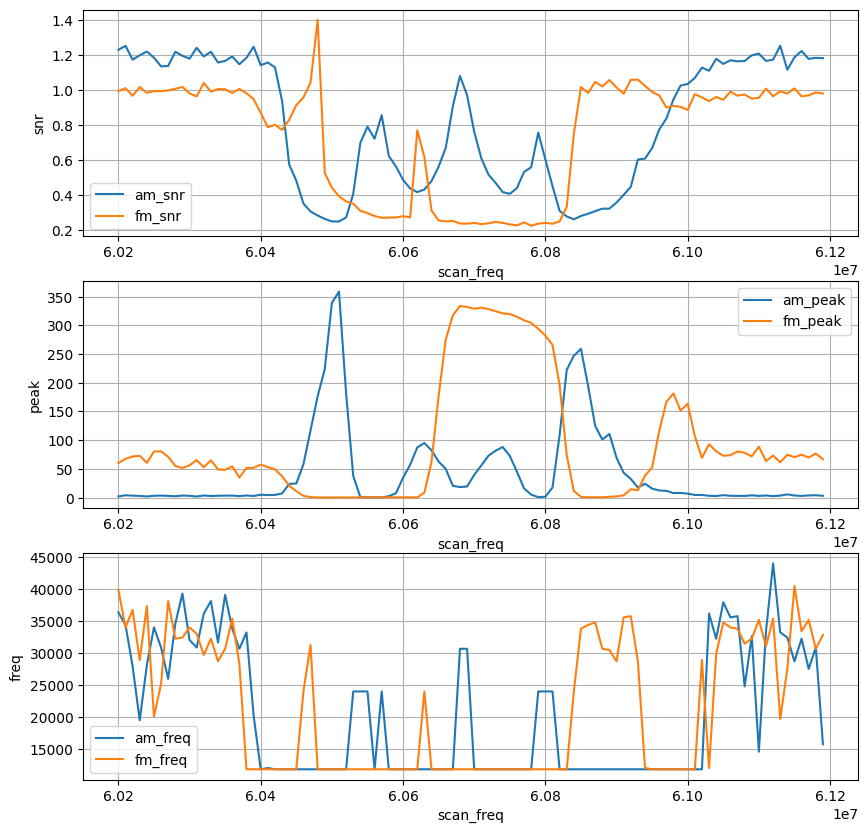

In [55]:
# Plot 1: am_snr, fm_snr vs scan_freq
# Plot 2: am_peak, fm_peak vs scan_freq
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(scan_freq, am_snr, label='am_snr')
ax[0].plot(scan_freq, fm_snr, label='fm_snr')
ax[0].set_xlabel('scan_freq')
ax[0].set_ylabel('snr')
ax[0].legend()
ax[0].grid()
ax[1].plot(scan_freq, am_peak, label='am_peak')
ax[1].plot(scan_freq, fm_peak, label='fm_peak')
ax[1].set_xlabel('scan_freq')
ax[1].set_ylabel('peak')
ax[1].legend()
ax[1].grid()
ax[2].plot(scan_freq, am_freq, label='am_freq')
ax[2].plot(scan_freq, fm_freq, label='fm_freq')
ax[2].set_xlabel('scan_freq')
ax[2].set_ylabel('freq')
ax[2].legend()
ax[2].grid()
plt.show()

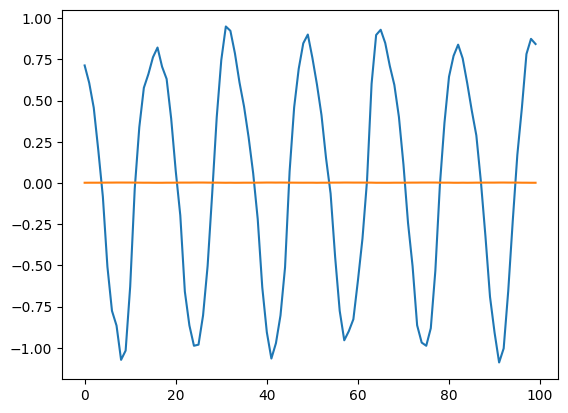

In [52]:
plt.plot(data[30, 0, :100])
plt.plot(data[30, 1, :100])

In [35]:
set_frequency(250e6, 250e6, 3)

In [72]:
scan_freq = np.arange(200e6, 100e6, -0.125e6, dtype=np.uint32)
# scan_freq = np.arange(60.2e6, 61.2e6, 0.01e6, dtype=np.uint32)
voltage = np.zeros(scan_freq.shape, dtype=np.float32)
for i, f in tqdm(enumerate(scan_freq), total=len(scan_freq)):
    set_frequency(f, f, 3)
    time.sleep(0.001)
    voltage[i] = np.mean(read_time_data(0b0100, 8, 100e3)[0])
voltage = voltage * 2.5 / 32768


  0%|          | 0/800 [00:00<?, ?it/s]

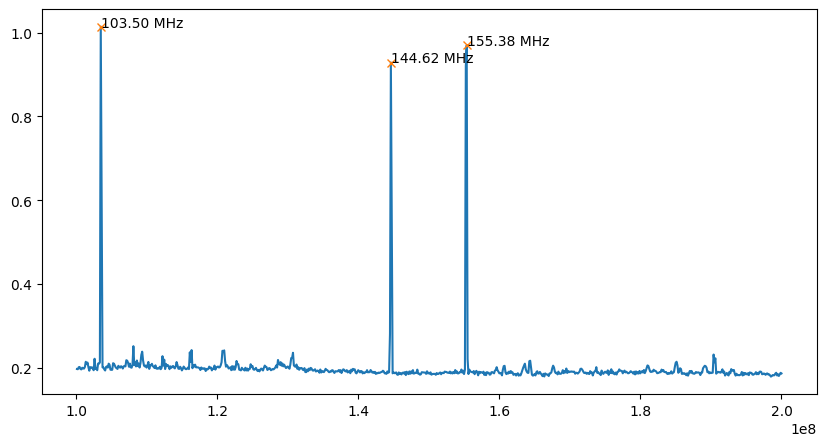

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(scan_freq, voltage)
peaks = scipy.signal.find_peaks(voltage, height=0.30, distance=10)[0]
plt.plot(scan_freq[peaks], voltage[peaks], 'x')
for p in peaks:
    plt.text(scan_freq[p], voltage[p], f"{scan_freq[p]/1e6:.2f} MHz")

In [ ]:
y = voltage

threshold = 0.2
# find symmetric center
center = np.sum((y * scan_freq)[y > threshold]) / np.sum(y[y > threshold])
print(center)

60685757.38728424


In [ ]:
set_frequency(center, center, 3)

In [52]:
com.close()